In [1]:
import tensorflow as tf
import os
import collections
import time
import random
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image
from tqdm import tqdm

#Custom Classes
from prep import Preparation
from gru_decoder import GRU_Decoder
from gru_encoder import GRU_Encoder
from cnn_encoder import CNN_Encoder

In [2]:
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
image_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(image_input, hidden_layer)

In [4]:
#Load labels
with open("../dataset/captions.json", "r") as jf:
    data = json.loads(jf.read())
data.pop("lstm_labels")
image_paths = list(data.keys())
random.shuffle(image_paths)

In [5]:
img_name_vector = []
for i in range(len(image_paths)):
    img_name_vector.append(f"../dataset/prep_data/{image_paths[i]}.jpg")
print(len(img_name_vector))

10177


In [6]:
#Test set heuristic
STRONG_WORDS = ["bald.", "bangs.", "big lips.", "big nose.", "black", "blond", "brown", "chubby.",
             "double chin.", "eyeglasses.", "goatee.", "gray", "", "mustache.", "beard.", "oval face.",
             "pale skin.", "pointy nose.", "receding hairline.", "rosy cheeks.", "sideburns.", "smiling.",
             "straight", "wavy", "wearing earings.", "wearing a hat.", "wearing lipstick.", "wearing a necklace.",
              "wearing a necktie.", "younger.", "older.", "hair", "He", "She", "she", "he"]

def heuristic(s1, s2):
    """
        :s1: List of strings for the target image
        :s2: List of strings for the distractor image
        :return: Closeness value
    """
    score = 0
    
    for t_sent in s1:
        if t_sent in s2:
            score += 1

    return score / len(s1)

In [7]:
#Split dataset do not train on images with everything in common
record = {} #Keeps a record of pairs id1 - id2 and id2 - id1
target_paths = list()
distractor_paths = list()

for _ in range(2200):
    random_numbers = []
    image_base = image_paths[0]

    while len(random_numbers) < 10:
        num = random.randint(1, len(image_paths)-1)

        image_pot = image_paths[num]

        score = heuristic(data[image_base], data[image_pot])

        in_record = (image_base in record and record[image_base] == image_pot) or (image_pot in record and record[image_pot] == image_base)

        if (num not in random_numbers) and (score < 1) and (not in_record):
            random_numbers.append(num)
    
    for k in random_numbers:
        image_distractor = image_paths[k]
        
        record[image_base] = image_distractor
        record[image_distractor] = image_base

        target_paths.append(image_base)
        distractor_paths.append(image_distractor)

    random.shuffle(image_paths)

In [8]:
print(f"Length targets: {len(target_paths)}")
print(f"Length distractors: {len(distractor_paths)}")

Length targets: 22000
Length distractors: 22000


In [8]:
#Split into train, val, and test set.
val_slice_index = int(len(target_paths)*0.8)
test_slice_index = int(len(target_paths)*0.9)

targ_name_train, targ_name_val, targ_name_test = target_paths[:val_slice_index], target_paths[val_slice_index:test_slice_index], target_paths[test_slice_index:]

dis_name_train, dis_name_val, dis_name_test = distractor_paths[:val_slice_index], distractor_paths[val_slice_index:test_slice_index], distractor_paths[test_slice_index:]


In [10]:
print(targ_name_test[0], dis_name_test[0])
print(f"Target Train {len(targ_name_train)}")
print(f"Distractor Train {len(dis_name_train)}")
print(f"Target Validation {len(targ_name_val)}")
print(f"Distractor Validation {len(dis_name_val)}")
print(f"Target Test {len(targ_name_test)}")
print(f"Distractor Test {len(dis_name_test)}")

5617 7533
Target Train 17600
Distractor Train 17600
Target Validation 2200
Distractor Validation 2200
Target Test 2200
Distractor Test 2200


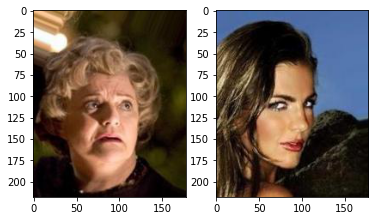

In [11]:
import matplotlib.image as mpimg
img_A = mpimg.imread(f"../dataset/prep_data/{targ_name_test[0]}.jpg")
img_B = mpimg.imread(f"../dataset/prep_data/{dis_name_test[0]}.jpg")

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

In [9]:
#Hyperparameters
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dims_speaker = 1024
embedding_dims_listener = 512
units = 512
vocab_size = 100
message_length = 10
num_steps = len(targ_name_train) // BATCH_SIZE

In [10]:
prep = Preparation()

In [303]:
training_data = tf.data.Dataset.from_tensor_slices((targ_name_train, dis_name_train))
training_data = training_data.map(lambda t, d: tf.numpy_function(prep.map_func, [t, d], [tf.float32, tf.float32]))
training_data = training_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
speaker = GRU_Decoder(embedding_dims_speaker, units, vocab_size)
listener = GRU_Encoder(embedding_dims_listener, units, vocab_size)
encoder_s = CNN_Encoder(embedding_dims_speaker)
encoder_l = CNN_Encoder(embedding_dims_listener)

In [12]:
optimizer_l = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer_s = tf.keras.optimizers.Adam(learning_rate=0.0007)

In [15]:
checkpoint_path = "./checkpointsa2a/train"
ckpt = tf.train.Checkpoint(speaker = speaker,
                           listener = listener,
                           encoder_s = encoder_s,
                           encoder_l = encoder_l,
                           optimizer_l = optimizer_l,
                           optimizer_s = optimizer_s)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [307]:
loss_plot_s = []
loss_plot_l = []

In [308]:
@tf.function
def train_step(u, targ, dist):
    loss_s = 0
    loss_l = 0

    hidden_s = speaker.reset_state(batch_size=targ.shape[0])
    hidden_l = listener.reset_state(batch_size=targ.shape[0])

    decoder_input = tf.expand_dims([1]*targ.shape[0],1,)
    m = decoder_input

    with tf.GradientTape() as tape_speaker:
        #Encode the image through CNN
        features = encoder_s(u)

        for i in range(1, 10):
            predictions, hidden, _ = speaker(decoder_input, features, hidden_s)

            pred_probs = tf.nn.softmax(predictions)
            log_probs = tf.math.log(pred_probs)

            with tape_speaker.stop_recording():
                col_indices = tf.cast(tf.random.categorical(predictions, 1, seed=42), tf.int32)
                row_indices = tf.reshape(tf.range(targ.shape[0]),(targ.shape[0],1))
                full_indices = tf.concat([row_indices,col_indices],axis=1)

                entropy = tf.math.multiply(pred_probs, log_probs)
                entropy = tf.gather_nd(entropy, full_indices)
                entropy = tf.reshape(entropy, (32,1))
            
            loss_ = tf.gather_nd(log_probs, full_indices) - entropy
          
            loss_s += loss_
            m = tf.concat([m, col_indices], 1)
            decoder_input = tf.expand_dims(m[:,i], 1)
            

        with tape_speaker.stop_recording():
            m = tf.one_hot(m, vocab_size)

            with tf.GradientTape() as tape_listener:

                features_t = encoder_l(targ)
                features_d = encoder_l(dist)

                #Compute loss for listener
                v = listener(m, hidden_l)

                with tape_listener.stop_recording():
                    rand_n = random.random()

                    if rand_n > 0.5:
                        left = features_t
                        right = features_d
                        y_t = tf.convert_to_tensor([[1,0]]*targ.shape[0],dtype=tf.float32)
                    else:
                        left = features_d
                        right = features_t
                        y_t = tf.convert_to_tensor([[0,1]]*targ.shape[0],dtype=tf.float32)
            
                x = tf.norm(tf.keras.layers.dot([left, v],axes=2,normalize=True),axis=(1,2))
                y = tf.norm(tf.keras.layers.dot([right, v],axes=2,normalize=True),axis=(1,2))
                x = tf.reshape(x, (x.shape[0],1))
                y = tf.reshape(y, (y.shape[0],1))
                z = tf.concat([x,y],axis=1)
                y_p = tf.nn.softmax(z)
                loss_l = loss_object(y_t, y_p)

                with tape_listener.stop_recording():
                    #rewards compute
                    mask = tf.math.greater(x, y)
                    rewards = tf.where(mask, 1, -1)

        rewards = tf.cast(rewards, tf.float32)
        loss_s = tf.math.multiply(loss_s, rewards)
        loss_s = -tf.reduce_mean(loss_s)

    trainable_vars_s = encoder_s.trainable_variables + speaker.trainable_variables
    # trainable_vars_s = speaker.trainable_variables
    #Gradient (speaker)
    gradients_s = tape_speaker.gradient(loss_s, trainable_vars_s)
    #Optimizer (speaker)
    optimizer_s.apply_gradients(zip(gradients_s, trainable_vars_s))

    #Trainable variables for encoder + decoder (listener)
    trainable_vars_l = encoder_l.trainable_variables + listener.trainable_variables
    #Gradient (listener)
    gradients_l = tape_listener.gradient(loss_l, trainable_vars_l)
    #Optimizer (listener)
    optimizer_l.apply_gradients(zip(gradients_l, trainable_vars_l))

    return loss_s, loss_l

In [309]:
val_data = tf.data.Dataset.from_tensor_slices((targ_name_val, dis_name_val))
val_data = val_data.map(lambda t, d: tf.numpy_function(prep.map_func, [t, d], [tf.float32, tf.float32]))
val_data = val_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [310]:
def evaluate(data):
    total_right = 0
    total_wrong = 0

    for (batch, (targ_tensor, dis_tensor)) in enumerate(data):
        hidden_s = speaker.reset_state(batch_size=targ_tensor.shape[0])
        hidden_l = listener.reset_state(batch_size=targ_tensor.shape[0])

        decoder_input = tf.expand_dims([1]*targ_tensor.shape[0],1)
        m = decoder_input

        u = tf.concat([targ_tensor, dis_tensor], -1)

        #Encode the image through CNN
        features = encoder_s(u)

        #make sure that these are 256+256 = 512 and not 32+32 = 64
        for i in range(1,10):
            predictions, hidden, _ = speaker(decoder_input, features, hidden_s)
            
            preds = tf.nn.softmax(predictions)
            indices = tf.math.argmax(predictions, axis=1)
            indices = tf.reshape(tf.cast(indices, tf.int32),(targ_tensor.shape[0],1))
            
            m = tf.concat([m, indices],1)

            decoder_input = indices

        m = tf.one_hot(m, vocab_size)

        features_t = encoder_l(targ_tensor)
        features_d = encoder_l(dis_tensor)

        rand_n = random.random()

        if rand_n > 0.5:
            left = features_t
            right = features_d
        else:
            left = features_d
            right = features_t

        v = listener(m, hidden_l)

        x = tf.norm(tf.keras.layers.dot([left, v],axes=2,normalize=True),axis=(1,2))
        y = tf.norm(tf.keras.layers.dot([right, v],axes=2,normalize=True),axis=(1,2))

        mask = tf.math.greater(x, y)
        total_right += np.sum(mask.numpy())
        total_wrong += np.sum(mask.numpy()==False)

    total = total_right + total_wrong

    acc = total_right / total

    return acc, total_right, total_wrong

In [1]:
EPOCHS = 15
for epoch in range(7, EPOCHS):
    start = time.time()
    total_loss_s = 0
    total_loss_l = 0

    for (batch, (targ_tensor, dis_tensor)) in enumerate(training_data):
      u = tf.concat([targ_tensor, dis_tensor], -1)

      s_loss, l_loss = train_step(u, targ_tensor, dis_tensor)
      total_loss_s += s_loss
      total_loss_l += l_loss

      if batch % 100 == 0:
          print ('Epoch {} Batch {} Speaker Loss {:.4f} Listener Loss {:.4f}'.format(
            epoch + 1, batch, s_loss.numpy(), l_loss.numpy()))

          # acc, tot_right, tot_wrong = evaluate(val_data)
          # tot = tot_right + tot_wrong
          # print(f'Epoch {epoch+1} Batch {batch} Accuracy of Validation Set {acc} for {tot} samples')

    # storing the epoch end loss value to plot later
    loss_plot_s.append(total_loss_s / num_steps)
    loss_plot_l.append(total_loss_l / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Speaker Loss {:.6f} Listener Loss {:.6f}'.format(epoch + 1,
                                         total_loss_s/num_steps, total_loss_l/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

NameError: name 'time' is not defined

In [312]:
test_data = tf.data.Dataset.from_tensor_slices((targ_name_test, dis_name_test))
test_data = test_data.map(lambda t, d: tf.numpy_function(prep.map_func, [t, d], [tf.float32, tf.float32]))
test_data = test_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

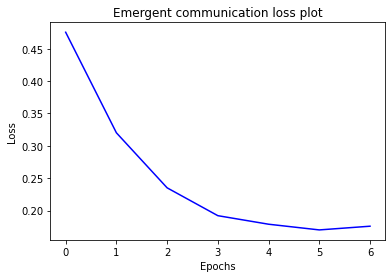

In [313]:
# plt.plot(-1 * loss_plot_s, color='r', label='Speaker loss')
plt.plot(loss_plot_l, color='b', label='Listener loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Emergent communication loss plot')
plt.show()

In [16]:
def map_func_test(img_name, img_name_2):
  img_tensor = np.load('../dataset/prep_data/'+img_name.decode('utf-8')+'.jpg.npy')
  img_tensor_2 = np.load('../dataset/prep_data/'+img_name_2.decode('utf-8')+'.jpg.npy')

  return img_tensor, img_tensor_2

In [17]:
with open("../dataset/best_captions.json", "r") as jfec:
    data = json.loads(jfec.read())

target_data = data['target_paths']
distractor_data = data['distractor_paths']

val_slice_index = int(len(target_data)*0.8)
test_slice_index = int(len(target_data)*0.9)

targ_test = target_data[test_slice_index:]

dis_test = distractor_data[test_slice_index:]

testset = tf.data.Dataset.from_tensor_slices((targ_test, dis_test))
testset = testset.map(lambda item1, item2: tf.numpy_function(
          map_func_test, [item1, item2], [tf.float32, tf.float32]))

testset = testset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

with open("../dataset/easy_captions.json", "r") as jfec:
    easy_data = json.loads(jfec.read())

target_easy_data = easy_data['target_paths']
distractor_easy_data = easy_data['distractor_paths']

val_slice_index = int(len(target_easy_data)*0.8)
test_slice_index = int(len(target_easy_data)*0.9)

targ_easy_test = target_easy_data[test_slice_index:]

dis_easy_test = distractor_easy_data[test_slice_index:]

testset_easy = tf.data.Dataset.from_tensor_slices((targ_easy_test, dis_easy_test))
testset_easy = testset_easy.map(lambda item1, item2: tf.numpy_function(
          map_func_test, [item1, item2], [tf.float32, tf.float32]))

testset_easy = testset_easy.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [25]:
def check_understanding(data):
    total_right = 0
    total_wrong = 0

    for (batch, (targ_tensor, dis_tensor)) in enumerate(data):
        hidden_s = speaker.reset_state(batch_size=targ_tensor.shape[0])
        hidden_l = listener.reset_state(batch_size=targ_tensor.shape[0])

        dec_input = tf.expand_dims([1] * targ_tensor.shape[0], 1)

        m = dec_input

        u = tf.concat([targ_tensor, dis_tensor], -1)

        #Encode the image through CNN
        features = encoder_s(u)

        #make sure that these are 256+256 = 512 and not 32+32 = 64
        for i in range(1,vocab_size):
            predictions, hidden, _ = speaker(dec_input, features, hidden_s)
            
            preds = tf.nn.softmax(predictions)
            indices = tf.math.argmax(predictions, axis=1)
            indices = tf.reshape(tf.cast(indices, tf.int32),(targ_tensor.shape[0],1))
            
            m = tf.concat([m, indices],1)

            dec_input = indices

        m = tf.one_hot(m, vocab_size)

        features_t = encoder_l(targ_tensor)
        features_d = encoder_l(dis_tensor)

        rand_n = random.random()

        left = features_t
        right = features_d

        v = listener(m, hidden_l)

        x = tf.norm(tf.keras.layers.dot([left, v],axes=2,normalize=True),axis=(1,2))
        y = tf.norm(tf.keras.layers.dot([right, v],axes=2,normalize=True),axis=(1,2))

        mask = tf.math.greater(x, y)
        total_right += np.sum(mask.numpy())
        total_wrong += np.sum(mask.numpy()==False)

    total = total_right + total_wrong

    acc = total_right / total

    return acc, total_right, total_wrong